In [1]:
import pandas as pd
import numpy as np
import os
import time
import pickle
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
sns.set()

## Login

In [6]:
ctg_url = 'https://cleaningtheglass.com'

In [7]:
ctg_login_url = 'https://cleaningtheglass.memberful.com/auth/sign_in'

In [8]:
def login(driver, cred, ctg_login_url=ctg_login_url):
    driver.get(ctg_login_url)

    # Get username & password
    with open(cred, 'r') as f:
        user_password = f.readlines()[0].replace('\n', '').split(', ')

    # Login
    userfield = driver.find_element_by_id('session_email')
    userfield.send_keys(user_password[0])
    driver.find_element_by_xpath("//button[@class='btn-main btn-expanded']").click()

    time.sleep(3)

    passwordfield = driver.find_element_by_id('session_password')
    passwordfield.send_keys(user_password[1])
    driver.find_element_by_xpath("//button[@data-session-form-target='passwordButton']").click()

In [9]:
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)



====== WebDriver manager ======
Current google-chrome version is 114.0.5735
Get LATEST chromedriver version for 114.0.5735 google-chrome
Driver [/Users/xulian/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


In [16]:
cred = 'ctg_cred.txt'
login(driver, cred)

## Basic Function

In [11]:
def fetch(driver):
    """
    Use BeautifulSoup to get the text of a web page.
    """
    d = driver.page_source
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("", d), "html.parser")
    return soup

## Scrape On-Off Data

In [12]:
def scrape_player_on_off_table(season, driver=driver):
    on_off_url = (
        f'{ctg_url}/stats/players?'
        'stat_category=onoff_efficiency&'
        f'season={season}'
    )
    driver.get(on_off_url)
    
    time.sleep(10)
    soup = fetch(driver)
    
    table = soup.find_all('table', {'id': 'players-table'})[0]
    
    # Build dataframe
    cols = ['Player', 'Age', 'Team', 'Pos', 'Min',
            'Diff_rank', 'Diff', 'Exp_W']
    for side in ['off', 'def']:
        cols += ['']
        for factor in ['Pts/Poss', 'eFG%', 'TOV%', 'OREB%', 'FTr']:
            cols = cols + [f'{side}_{factor}_rank', f'{side}_{factor}']

    data = [[td.text for td in row.find_all('td')]
            for row in table.find_all('tbody')[0].find_all('tr')]
    df = pd.DataFrame(data, columns=cols).drop('', axis=1)
    for col in cols:
        if 'rank' in col:
            df[col] = df[col].apply(lambda x: x.strip('\n').strip(' ').strip('\n'))
    df['season'] = season
    
    return df
    

In [13]:
seasons = list(range(2017, 2023))

In [18]:
season_dfs = []
for season in tqdm(seasons):
    season_dfs.append(scrape_player_on_off_table(season))

100%|█████████████████████████████████████████████| 6/6 [02:23<00:00, 24.00s/it]


In [19]:
driver.close()

In [20]:
df = pd.concat(season_dfs)
# df.head()

In [21]:
df.to_csv('ctg_on_off.csv', index=False)

## Overview

In [22]:
df = pd.read_csv('ctg_on_off.csv')
df.shape

(3034, 29)

In [23]:
df = df[df['Min'] >= 400]
df.shape

(2321, 29)

In [24]:
df.head()

,Player,Age,Team,Pos,Min,Diff_rank,Diff,Exp_W,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,def_Pts/Poss_rank,def_Pts/Poss,def_eFG%_rank,def_eFG%,def_TOV%_rank,def_TOV%,def_OREB%_rank,def_OREB%,def_FTr_rank,def_FTr,season
0,Alex Abrines,24.3,OKC,Wing,1066.0,46.0,-0.7,-2.0,67.0,1.4,37.0,-0.8%,89.0,-1.4%,12.0,-3.7%,79.0,2.2,32.0,2.1,49.0,-0.0%,24.0,-1.0%,9.0,+3.0%,18.0,2.8,2017.0
1,Quincy Acy,27.1,BKN,Big,1287.0,67.0,2.3,6.0,70.0,1.7,80.0,+1.7%,24.0,+0.8%,30.0,-1.6%,45.0,-0.5,54.0,-0.7,50.0,-0.1%,66.0,+0.6%,63.0,-0.7%,25.0,2.1,2017.0
2,Steven Adams,24.3,OKC,Big,2465.0,88.0,7.6,19.0,91.0,6.3,69.0,+0.9%,11.0,+1.6%,100.0,+11.6%,14.0,-3.3,62.0,-1.4,41.0,+0.5%,34.0,-0.6%,84.0,-2.8%,67.0,-1.0,2017.0
3,Arron Afflalo,32.0,ORL,Wing,618.0,28.0,-4.1,-9.0,30.0,-2.7,55.0,+0.1%,23.0,+0.8%,33.0,-1.2%,78.0,1.9,37.0,1.4,86.0,-2.4%,9.0,-1.9%,10.0,+2.9%,58.0,-0.3,2017.0
4,LaMarcus Aldridge,32.3,SAS,Big,2474.0,93.0,10.4,27.0,91.0,6.3,74.0,+1.3%,92.0,-1.7%,65.0,+1.1%,36.0,-1.2,84.0,-4.1,75.0,-1.5%,25.0,-0.9%,87.0,-3.1%,41.0,0.8,2017.0


In [25]:
positions = ['Point', 'Combo', 'Wing', 'Forward', 'Big']

<Axes: xlabel='def_Pts/Poss', ylabel='Pos'>

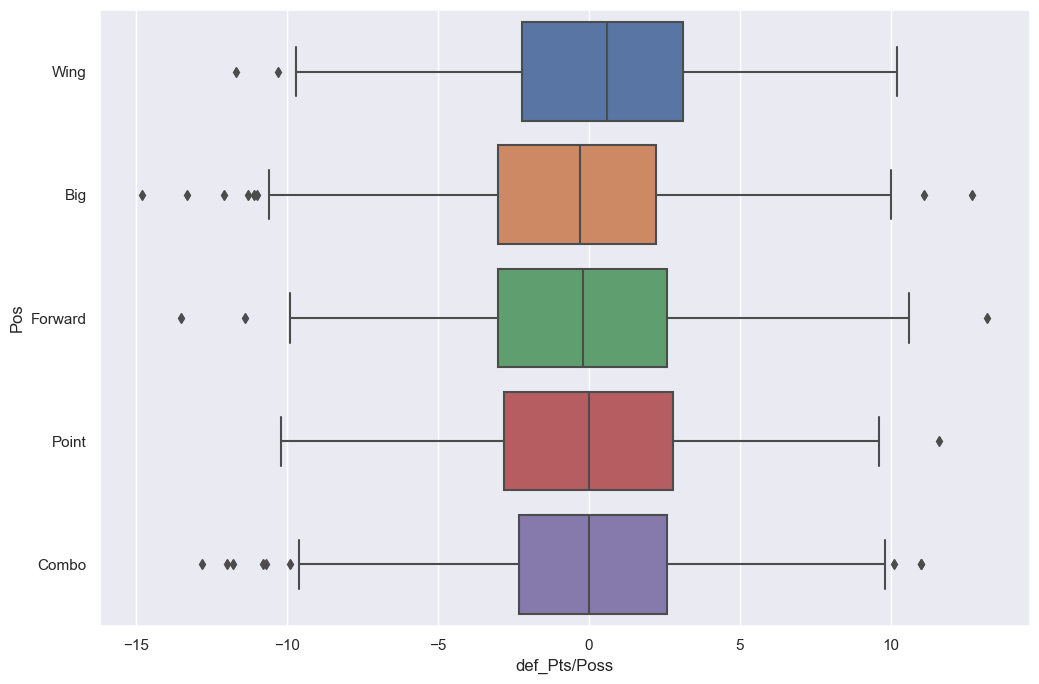

In [26]:
figsize(12, 8)
sns.boxplot(x='def_Pts/Poss', y='Pos', data=df)

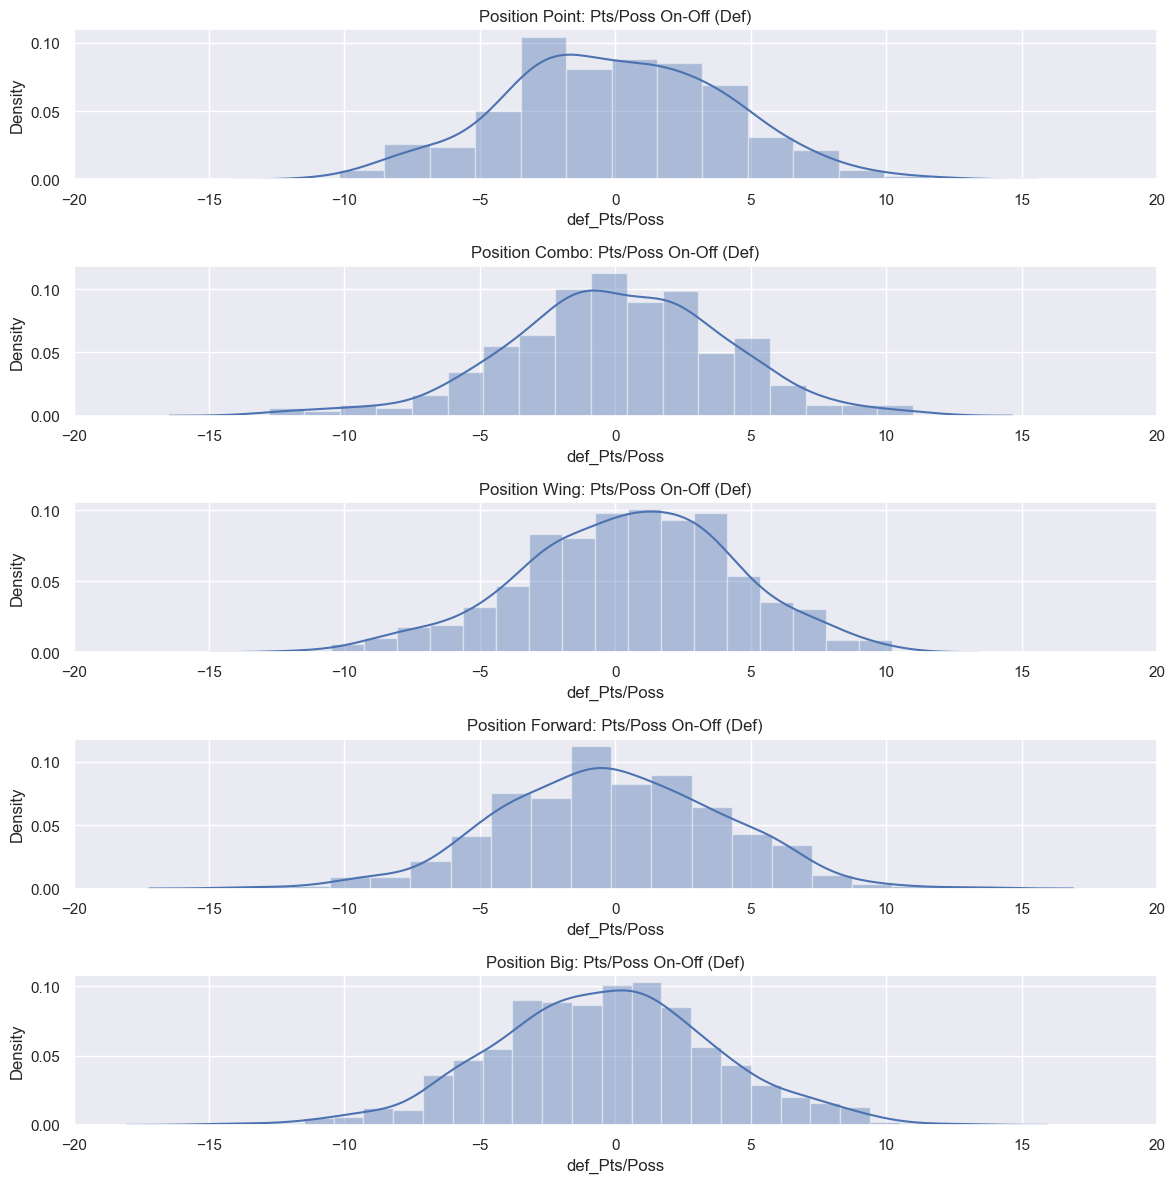

In [27]:
figsize(12, 12)
for i, pos in enumerate(positions, 1):
    plt.subplot(5, 1, i)
    sns.distplot(df[df['Pos'] == pos]['def_Pts/Poss'])
    plt.title(f'Position {pos}: Pts/Poss On-Off (Def)')
    plt.xlim(-20, 20)
plt.tight_layout()